In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

DATA_DIR = r'C:\Users\Kardelen\Desktop\dlp\garbage-dataset'
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
class_names = dataset.classes
print("Sınıflar:", class_names)


Kullanılacak cihaz: cuda
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [3]:

BATCH_SIZE = 32
targets = [s[1] for s in dataset.samples]

train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=targets, random_state=42
)
temp_targets = [targets[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_targets, random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Eğitim: 13833, Val: 2964, Test: 2965


In [4]:

class CNN6Layers(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN6Layers, self).__init__()
        
        # Katman 1: Giriş (3) -> 16 Filtre
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # Boyut: 224 -> 112
        self.drop1 = nn.Dropout(0.25)

        # Katman 2: 16 -> 32 Filtre
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # Boyut: 112 -> 56
        self.drop2 = nn.Dropout(0.25)

        # Katman 3: 32 -> 64 Filtre
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # Boyut: 56 -> 28
        self.drop3 = nn.Dropout(0.25)

        # Katman 4: 64 -> 128 Filtre
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2) # Boyut: 28 -> 14
        self.drop4 = nn.Dropout(0.25)

        # --- YENİ EKLENEN KATMANLAR ---

        # Katman 5: 128 -> 256 Filtre
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2) # Boyut: 14 -> 7
        self.drop5 = nn.Dropout(0.25)

        # Katman 6: 256 -> 512 Filtre
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool6 = nn.MaxPool2d(2, 2) # Boyut: 7 -> 3 (Tam sayı bölme)
        self.drop6 = nn.Dropout(0.25)

        # --- Flatten (Düzleştirme) ---
        # Son boyutumuz: 512 kanal x 3 yükseklik x 3 genişlik
        self.fc1 = nn.Linear(512 * 3 * 3, 1024) # Nöron sayısını artırdık
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop5(self.pool5(F.relu(self.conv5(x)))) # Yeni
        x = self.drop6(self.pool6(F.relu(self.conv6(x)))) # Yeni
        
        x = x.view(x.size(0), -1) # Düzleştirme
        x = self.drop_fc(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
NUM_TRIALS = 5
lr_candidates = 10**np.random.uniform(-5, -2, NUM_TRIALS)

best_lr = None
best_val_acc = 0.0
best_model_state = None

random_search_epochs = 5
def train_epoch(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return running_loss / len(train_loader.dataset), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(val_loader.dataset), correct / total


In [6]:
for i, lr in enumerate(lr_candidates):
    print(f"Deneme {i+1}/{NUM_TRIALS}: lr={lr:.6f}")
    model = CNN6Layers().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=random_search_epochs)
    patience = 3; counter = 0; best_trial_val_acc = 0.0

    for epoch in range(random_search_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scheduler, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        print(f"  Epoch {epoch+1}/{random_search_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_trial_val_acc:
            best_trial_val_acc = val_acc
            counter = 0
            trial_best_state = model.state_dict()
        else:
            counter +=1
            if counter >= patience:
                break
    if best_trial_val_acc > best_val_acc:
        best_val_acc = best_trial_val_acc
        best_lr = lr
        best_model_state = trial_best_state
    del model, optimizer, criterion
    torch.cuda.empty_cache()

print(f"En iyi LR: {best_lr:.6f}, Best Val Acc: {best_val_acc:.4f}")


Deneme 1/5: lr=0.000058
  Epoch 1/5 | Train Loss: 1.9721 | Val Loss: 1.9292 | Train Acc: 0.3327 | Val Acc: 0.3941
  Epoch 2/5 | Train Loss: 1.5809 | Val Loss: 1.7094 | Train Acc: 0.4533 | Val Acc: 0.4733
  Epoch 3/5 | Train Loss: 1.4298 | Val Loss: 1.6272 | Train Acc: 0.4989 | Val Acc: 0.4848
  Epoch 4/5 | Train Loss: 1.3519 | Val Loss: 1.5948 | Train Acc: 0.5284 | Val Acc: 0.4852
  Epoch 5/5 | Train Loss: 1.3045 | Val Loss: 1.5723 | Train Acc: 0.5446 | Val Acc: 0.4993
Deneme 2/5: lr=0.000014
  Epoch 1/5 | Train Loss: 2.1386 | Val Loss: 2.1523 | Train Acc: 0.2837 | Val Acc: 0.2972
  Epoch 2/5 | Train Loss: 1.9454 | Val Loss: 2.0497 | Train Acc: 0.3481 | Val Acc: 0.2898
  Epoch 3/5 | Train Loss: 1.8352 | Val Loss: 1.9888 | Train Acc: 0.3741 | Val Acc: 0.3097
  Epoch 4/5 | Train Loss: 1.7720 | Val Loss: 1.9721 | Train Acc: 0.3932 | Val Acc: 0.3168
  Epoch 5/5 | Train Loss: 1.7452 | Val Loss: 1.9570 | Train Acc: 0.4029 | Val Acc: 0.3249
Deneme 3/5: lr=0.000139
  Epoch 1/5 | Train Loss: 1.

In [7]:
model = CNN6Layers().to(device)
model.load_state_dict(best_model_state)
final_training_epochs = 20
final_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
final_optimizer = optim.Adam(model.parameters(), lr=best_lr)
final_criterion = nn.CrossEntropyLoss()
final_scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=final_training_epochs)
patience = 3; counter = 0; best_final_val_acc = 0.0

for epoch in range(final_training_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, final_optimizer, final_criterion, final_scheduler, device)
    val_loss, val_acc = validate_epoch(model, val_loader, final_criterion, device)

    final_history['train_loss'].append(train_loss)
    final_history['val_loss'].append(val_loss)
    final_history['train_acc'].append(train_acc)
    final_history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_final_val_acc:
        best_final_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_final_model.pth')
    else:
        counter +=1
        if counter >= patience:
            print("Early stopping!")
            break

model.load_state_dict(torch.load('best_final_model.pth', weights_only=True))



Epoch 1 | Train Loss: 0.9800 | Val Loss: 1.3103 | Val Acc: 0.5526
Epoch 2 | Train Loss: 0.8827 | Val Loss: 1.2005 | Val Acc: 0.6083
Epoch 3 | Train Loss: 0.8188 | Val Loss: 1.0608 | Val Acc: 0.6437
Epoch 4 | Train Loss: 0.7294 | Val Loss: 1.0978 | Val Acc: 0.6296
Epoch 5 | Train Loss: 0.6424 | Val Loss: 0.9837 | Val Acc: 0.6663
Epoch 6 | Train Loss: 0.5706 | Val Loss: 0.9209 | Val Acc: 0.7078
Epoch 7 | Train Loss: 0.5009 | Val Loss: 1.0766 | Val Acc: 0.6775
Epoch 8 | Train Loss: 0.4449 | Val Loss: 0.9456 | Val Acc: 0.7011
Epoch 9 | Train Loss: 0.3767 | Val Loss: 0.9913 | Val Acc: 0.7051
Early stopping!


<All keys matched successfully>

In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels, all_preds)
    return all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen Sınıf'); plt.ylabel('Gerçek Sınıf'); plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.show()
    

def plot_f1_per_class(f1_scores, class_names):
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, f1_scores, color='mediumseagreen')
    for i, score in enumerate(f1_scores):
        plt.text(i, score + 0.02, f'{score:.4f}', ha='center')
    plt.title('Sınıf Başına F1 Skoru'); plt.xlabel('Sınıf Adları'); plt.ylabel('F1 Skoru'); plt.ylim(0,1.0)
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

def plot_overall_metrics(test_acc, f1_macro):
    metrics = ['TEST Accuracy', 'Macro F1 Skoru']
    scores = [test_acc, f1_macro]
    plt.figure(figsize=(6,5))
    plt.bar(metrics, scores, color=['skyblue','lightcoral']); plt.ylim(0,1.0)
    for i, score in enumerate(scores):
        plt.text(i, score+0.02, f'{score:.4f}', ha='center', color='black')
    plt.title('Test Metrikleri'); plt.ylabel('Skor Değeri'); plt.tight_layout(); plt.show()

def plot_training_history(history):
    epochs = np.arange(1,len(history['train_loss'])+1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Eğitim & Val Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo', label='Training acc')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation acc')
    plt.title('Eğitim & Val Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()

def show_random_test_images(model, test_loader, device, class_names, num_samples=4):
    for images_batch, labels_batch in test_loader: break
    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
    model.eval()
    with torch.no_grad():
        outputs_batch = model(images_batch)
    _, predicted_indices_batch = torch.max(outputs_batch, 1)
    random_indices = random.sample(range(len(images_batch)), num_samples)
    fig, axes = plt.subplots(1,num_samples,figsize=(12,3))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        img = images_batch[idx].cpu().numpy().transpose((1,2,0))
        mean = np.array([0.485,0.456,0.406]); std=np.array([0.229,0.224,0.225])
        img = np.clip(std*img + mean,0,1)
        true_label = class_names[labels_batch[idx].item()]
        pred_label = class_names[predicted_indices_batch[idx].item()]
        title_color = 'green' if true_label==pred_label else 'red'
        ax.set_title(f"P:{pred_label}\n(R:{true_label})", color=title_color)
        ax.imshow(img); ax.axis('off')
    plt.tight_layout(); plt.show()


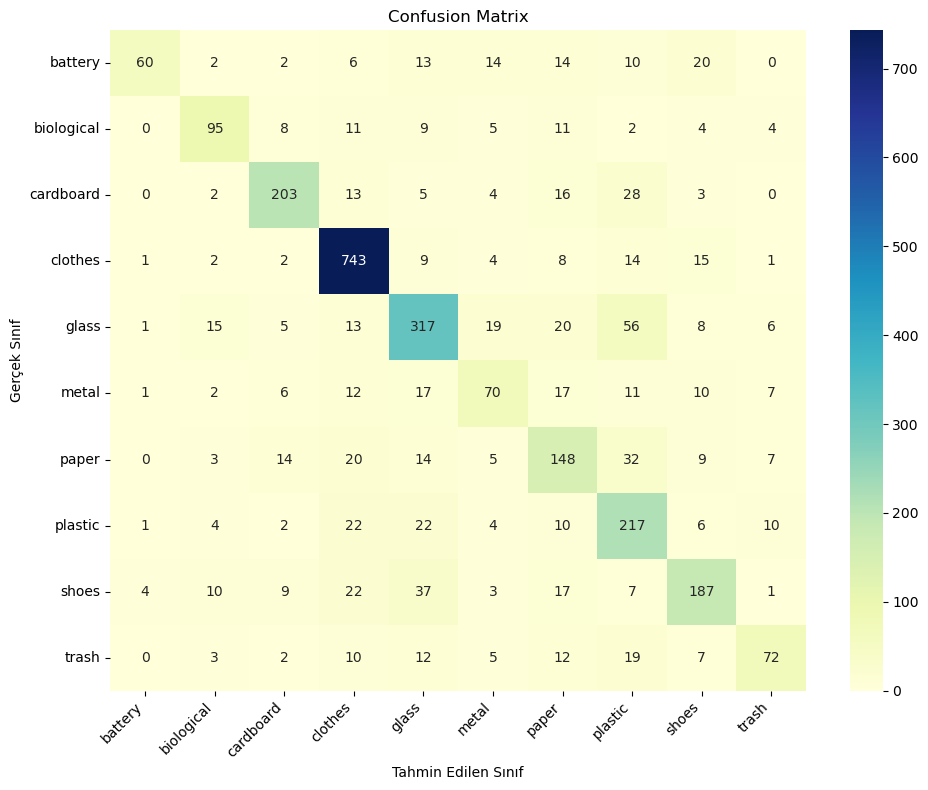

In [9]:
all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc = evaluate_model(model, test_loader, device, class_names)

plot_confusion_matrix(cm, class_names)


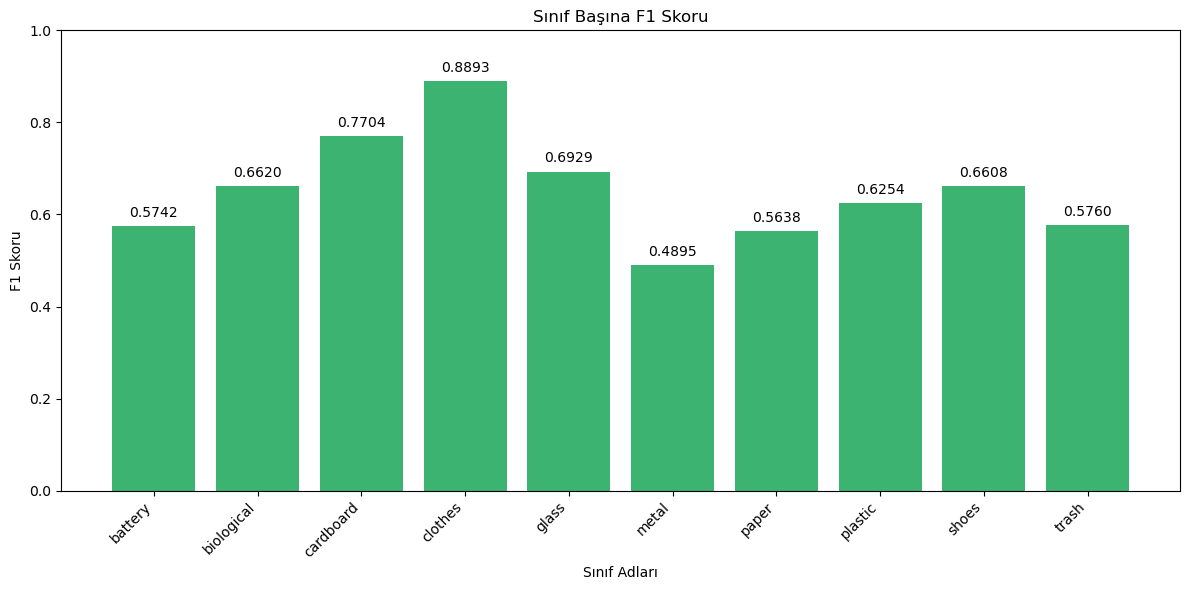

In [10]:
plot_f1_per_class(f1_per_class, class_names)


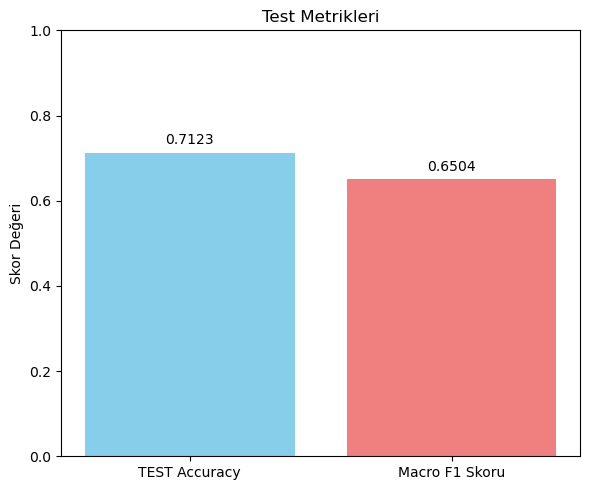

In [11]:
plot_overall_metrics(test_acc, f1_macro)


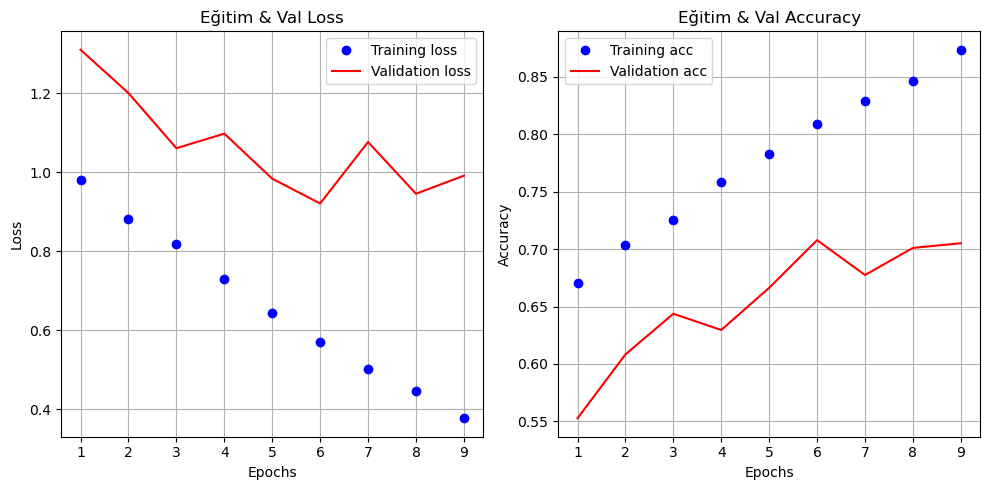

In [12]:
plot_training_history(final_history)



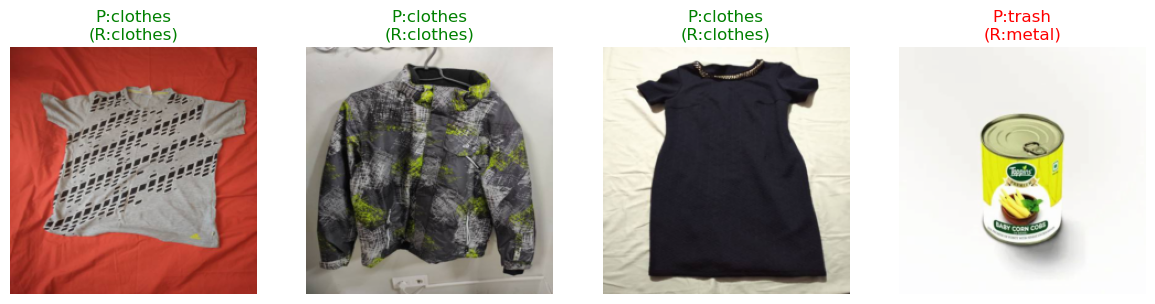

In [13]:
show_random_test_images(model, test_loader, device, class_names)